Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Generate Synthetic Data with CTGAN

* References
  * CTGAN paper: https://github.com/hanhanwu/Hanhan_My_Garden/blob/main/code/secret_guest/research/CTGAN%20paper.pdf
  * CTGAN Github: https://github.com/sdv-dev/CTGAN/tree/master
  * Check CTGAN parameters: https://github.com/sdv-dev/CTGAN/blob/master/ctgan/synthesizers/ctgan.py
  
* <b>NOTES</b>
  * CTGAN can't recognize pandas `category` data type, have to keep `object` type in this case.

In [1]:
import pandas as pd
import numpy as np

from ttictoc import tic, toc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from ctgan import CTGAN
import lightgbm as lgb
from lightgbm import LGBMClassifier

from utils import *

import warnings
warnings.filterwarnings('ignore')

## Load Real Data

In [2]:
raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
print(raw_df.shape)

raw_df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [3]:
target = 'deposit'
num_cols = [col for col in raw_df.columns if raw_df[col].dtype != 'O' and col != target]
cat_cols = [col for col in raw_df.columns if raw_df[col].dtype == 'O' and col != target]

print(len(num_cols), len(cat_cols))
print(num_cols)
print(cat_cols)

7 9
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(raw_df.drop(target, axis=1), raw_df[target], 
                                                    test_size=0.25, random_state=10,
                                                    stratify=raw_df[target])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(len(X_train)/len(raw_df))
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_test.head()

(8371, 16) (2791, 16) (8371,) (2791,)
0.7499552051603655
0    0.526102
1    0.473898
Name: deposit, dtype: float64
0    0.526335
1    0.473665
Name: deposit, dtype: float64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,33,admin.,married,secondary,no,7,yes,no,cellular,17,apr,612,1,148,1,failure
1,59,retired,married,tertiary,no,422,yes,no,cellular,14,may,647,4,-1,0,unknown
2,25,student,single,unknown,no,3,no,no,cellular,26,may,170,1,-1,0,unknown
3,51,blue-collar,married,primary,no,4497,yes,no,unknown,15,may,276,3,-1,0,unknown
4,49,admin.,single,secondary,no,293,no,no,cellular,28,jun,452,1,-1,0,unknown


## Generate Synthetic Data

* NOTE: Lady H. forgot to set random state for CTGAN and the output here is not replicable. YOu can add `ctgan_pos.set_random_state(10)` between `CTGAN()` and its `fit()` function.

In [10]:
cols = list(X_train.columns)

In [9]:
tic()
ctgan_10 = CTGAN(epochs=10)
ctgan_10.fit(X_train, cols)
print(f'{round(toc()/60)} min')

syn_X_train_10 = ctgan_10.sample(len(X_train))
print(X_train.shape, syn_X_train_10.shape)
syn_X_train_10.head()

17 min
(8371, 16) (8371, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,36,admin.,single,tertiary,no,6203,no,no,cellular,30,jan,187,1,-1,0,unknown
1,33,housemaid,married,tertiary,no,1633,no,no,cellular,13,sep,775,2,-1,0,unknown
2,40,technician,single,tertiary,no,-11,yes,no,cellular,27,feb,295,4,-1,0,unknown
3,35,technician,single,primary,no,102,no,no,cellular,5,jul,43,2,-1,26,other
4,44,blue-collar,married,secondary,no,0,no,no,cellular,4,nov,1405,1,-1,0,success


In [8]:
syn_X_train_10.to_csv('ctgan_syn_X_train_10.csv', index=False)

In [11]:
tic()
ctgan_50 = CTGAN(epochs=50)
ctgan_50.fit(X_train, cols)
print(f'{round(toc()/60)} min')

syn_X_train_50 = ctgan_50.sample(len(X_train))
print(syn_X_train_50.shape, syn_X_train_50.shape)
syn_X_train_50.head()

165 min
(8371, 16) (8371, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,31,admin.,married,tertiary,no,175,no,no,cellular,8,feb,351,2,-1,0,unknown
1,41,management,married,primary,no,1780,yes,no,cellular,26,jun,334,2,134,40,other
2,35,blue-collar,married,secondary,no,1423,yes,no,unknown,28,aug,56,2,167,0,unknown
3,54,management,single,secondary,no,470,yes,no,cellular,28,jun,106,2,256,4,unknown
4,46,blue-collar,divorced,secondary,no,364,no,no,unknown,7,aug,22,3,251,0,unknown


In [12]:
syn_X_train_50.to_csv('ctgan_syn_X_train_50.csv', index=False)

## Evaluate Generated Synthetic Data

* Compare distributions of real data and synthetic data
* Compare model efficacy using real data and synthetic data
* Also compare different synthetic data performance
  * Synthetic data generated with 10 epochs
  * Synthetic data generated with 50 epochs
* NOTE: In this case, we don't have data validity concerns in generated synthetic data

### Compare Distributions

In [5]:
syn_X_train_10 = pd.read_csv('ctgan_syn_X_train_10.csv')
syn_X_train_50 = pd.read_csv('ctgan_syn_X_train_50.csv')

# check data validatity
print(min(syn_X_train_10['pdays']), min(syn_X_train_50['pdays']))

-1 -1


In [6]:
real_num_df = X_train[num_cols]
real_num_df['data_mark'] = 'real'
real_cat_df = X_train[cat_cols]
real_cat_df['data_mark'] = 'real'

syn10_num_df = syn_X_train_10[num_cols]
syn10_num_df['data_mark'] = 'synthetic_10'
syn10_cat_df = syn_X_train_10[cat_cols]
syn10_cat_df['data_mark'] = 'synthetic_10'

syn50_num_df = syn_X_train_50[num_cols]
syn50_num_df['data_mark'] = 'synthetic_50'
syn50_cat_df = syn_X_train_50[cat_cols]
syn50_cat_df['data_mark'] = 'synthetic_50'

In [7]:
compare_num_df1 = pd.concat([real_num_df, syn10_num_df], ignore_index=True)
compare_cat_df1 = pd.concat([real_cat_df, syn10_cat_df], ignore_index=True)
compare_num_df1['balance'] = compare_num_df1['balance'].astype('float')
compare_num_df1['logged_balance'] = np.log(abs(compare_num_df1['balance']) + 1)\
                                            * np.sign(compare_num_df1['balance'])

compare_num_df2 = pd.concat([real_num_df, syn50_num_df], ignore_index=True)
compare_cat_df2 = pd.concat([real_cat_df, syn50_cat_df], ignore_index=True)
compare_num_df2['balance'] = compare_num_df2['balance'].astype('float')
compare_num_df2['logged_balance'] = np.log(abs(compare_num_df2['balance']) + 1)\
                                             * np.sign(compare_num_df2['balance'])

print(compare_num_df1.shape, compare_cat_df1.shape, compare_num_df2.shape, compare_cat_df2.shape)

(16742, 9) (16742, 10) (16742, 9) (16742, 10)


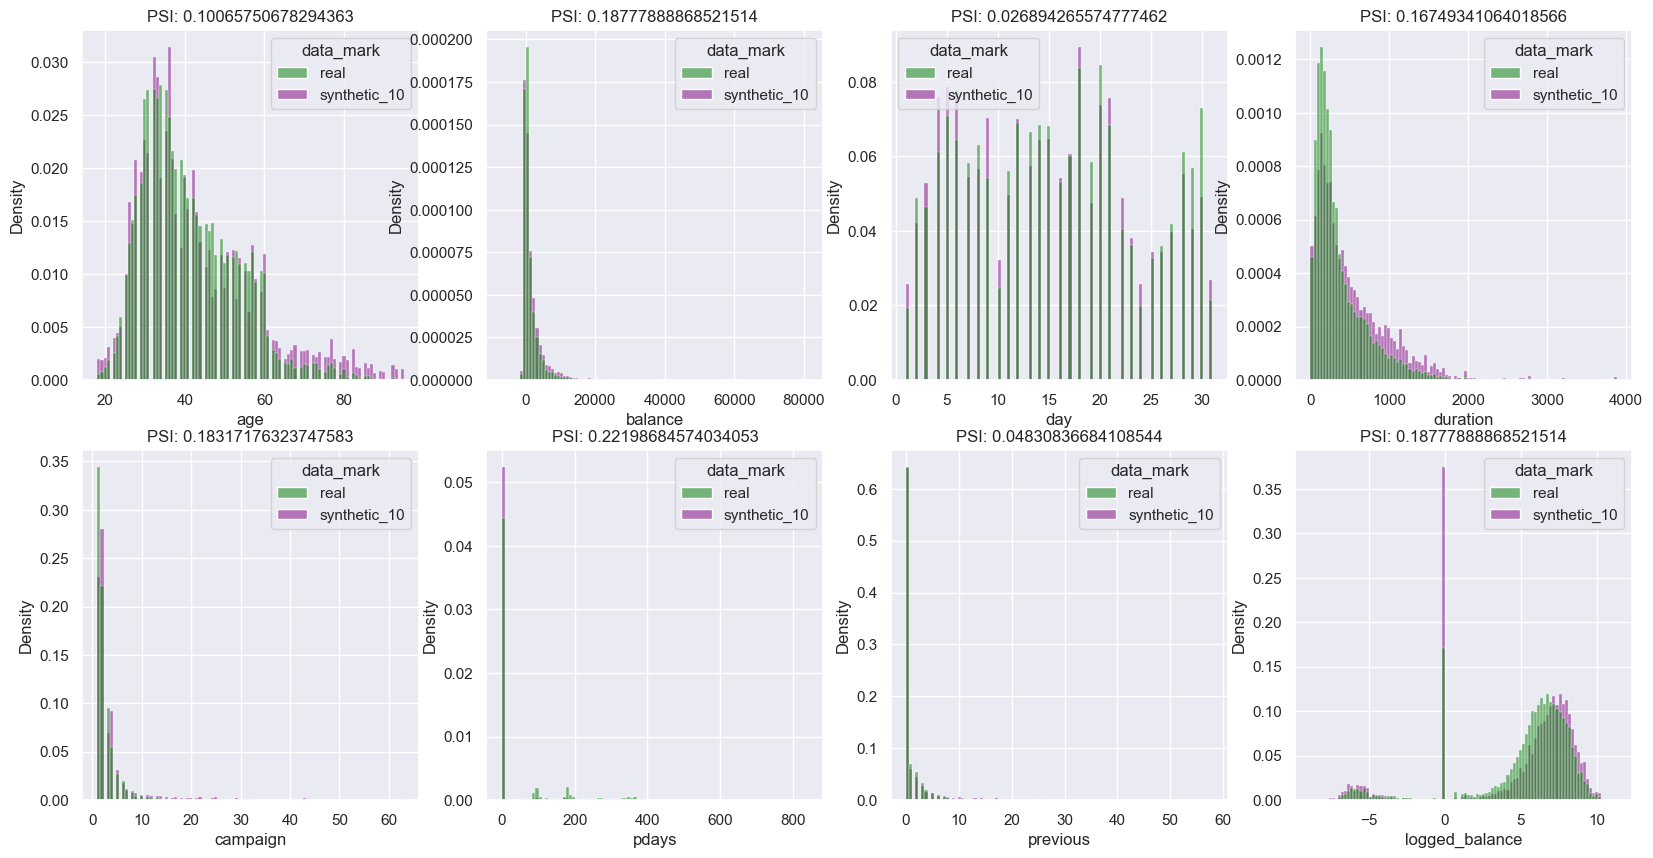

In [13]:
plot_num_feature_distribution_per_group(compare_num_df1, group_col='data_mark', 
                                        n_rows=2, n_cols=4, exclude_cols=['data_mark'], 
                                        figsize=[20, 10], font_scale=1,
                                        group_values=['real', 'synthetic_10'],
                                        bins=100, palette=['green', 'purple'],
                                        distribution_metrics='psi', enable_dist_comp=True)

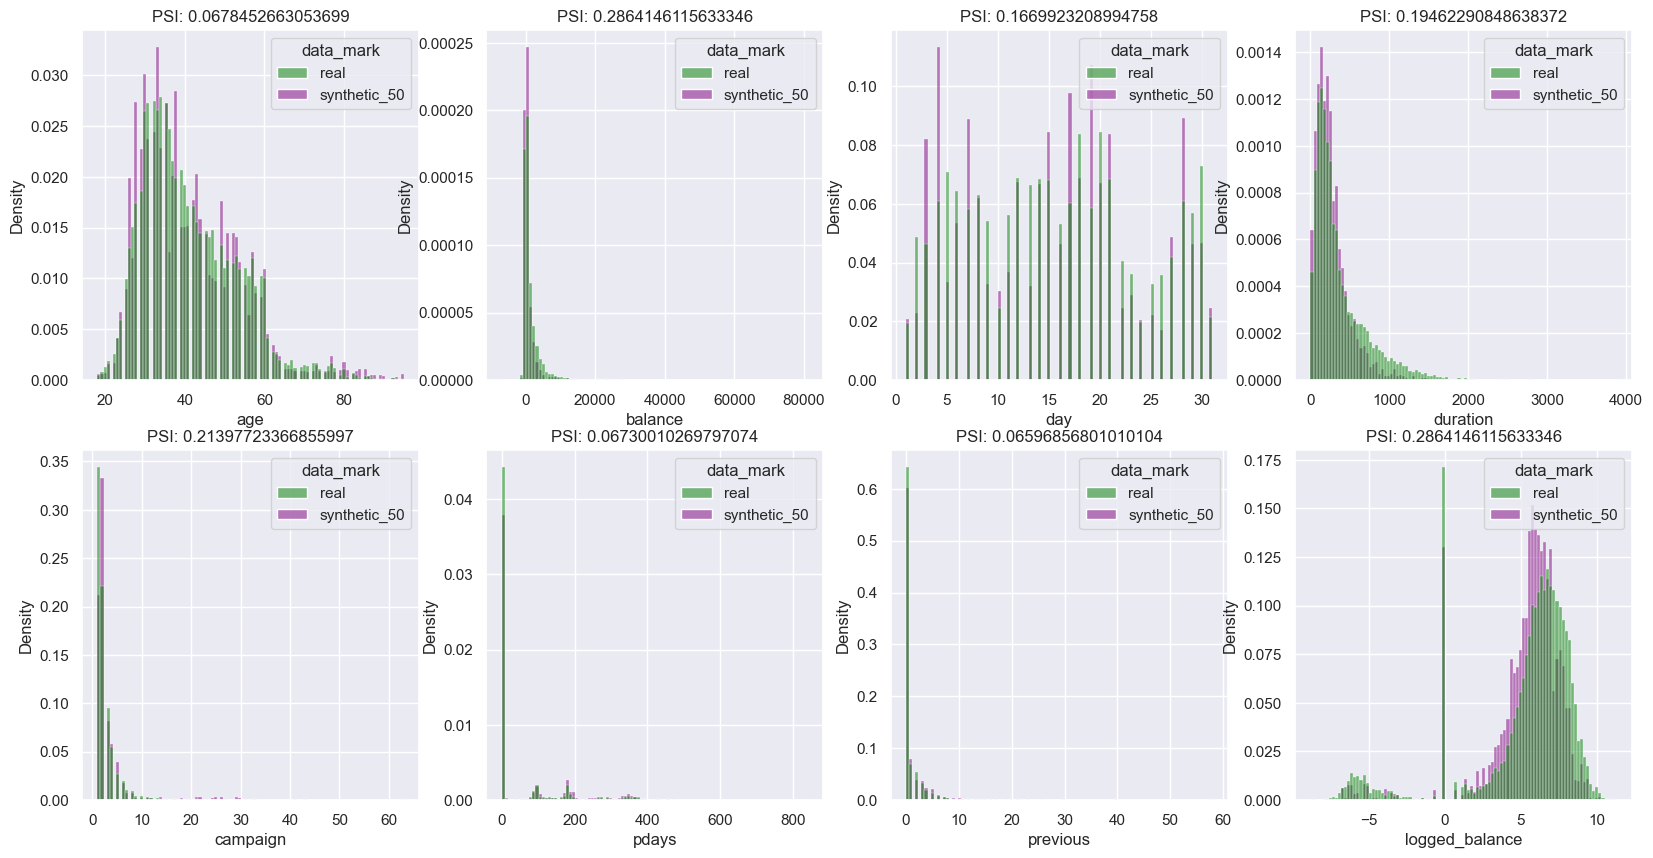

In [14]:
plot_num_feature_distribution_per_group(compare_num_df2, group_col='data_mark',
                                        n_rows=2, n_cols=4, exclude_cols=['data_mark'], 
                                        figsize=[20, 10], font_scale=1,
                                        group_values=['real', 'synthetic_50'],
                                        bins=100, palette=['green', 'purple'],
                                        distribution_metrics='psi', enable_dist_comp=True)

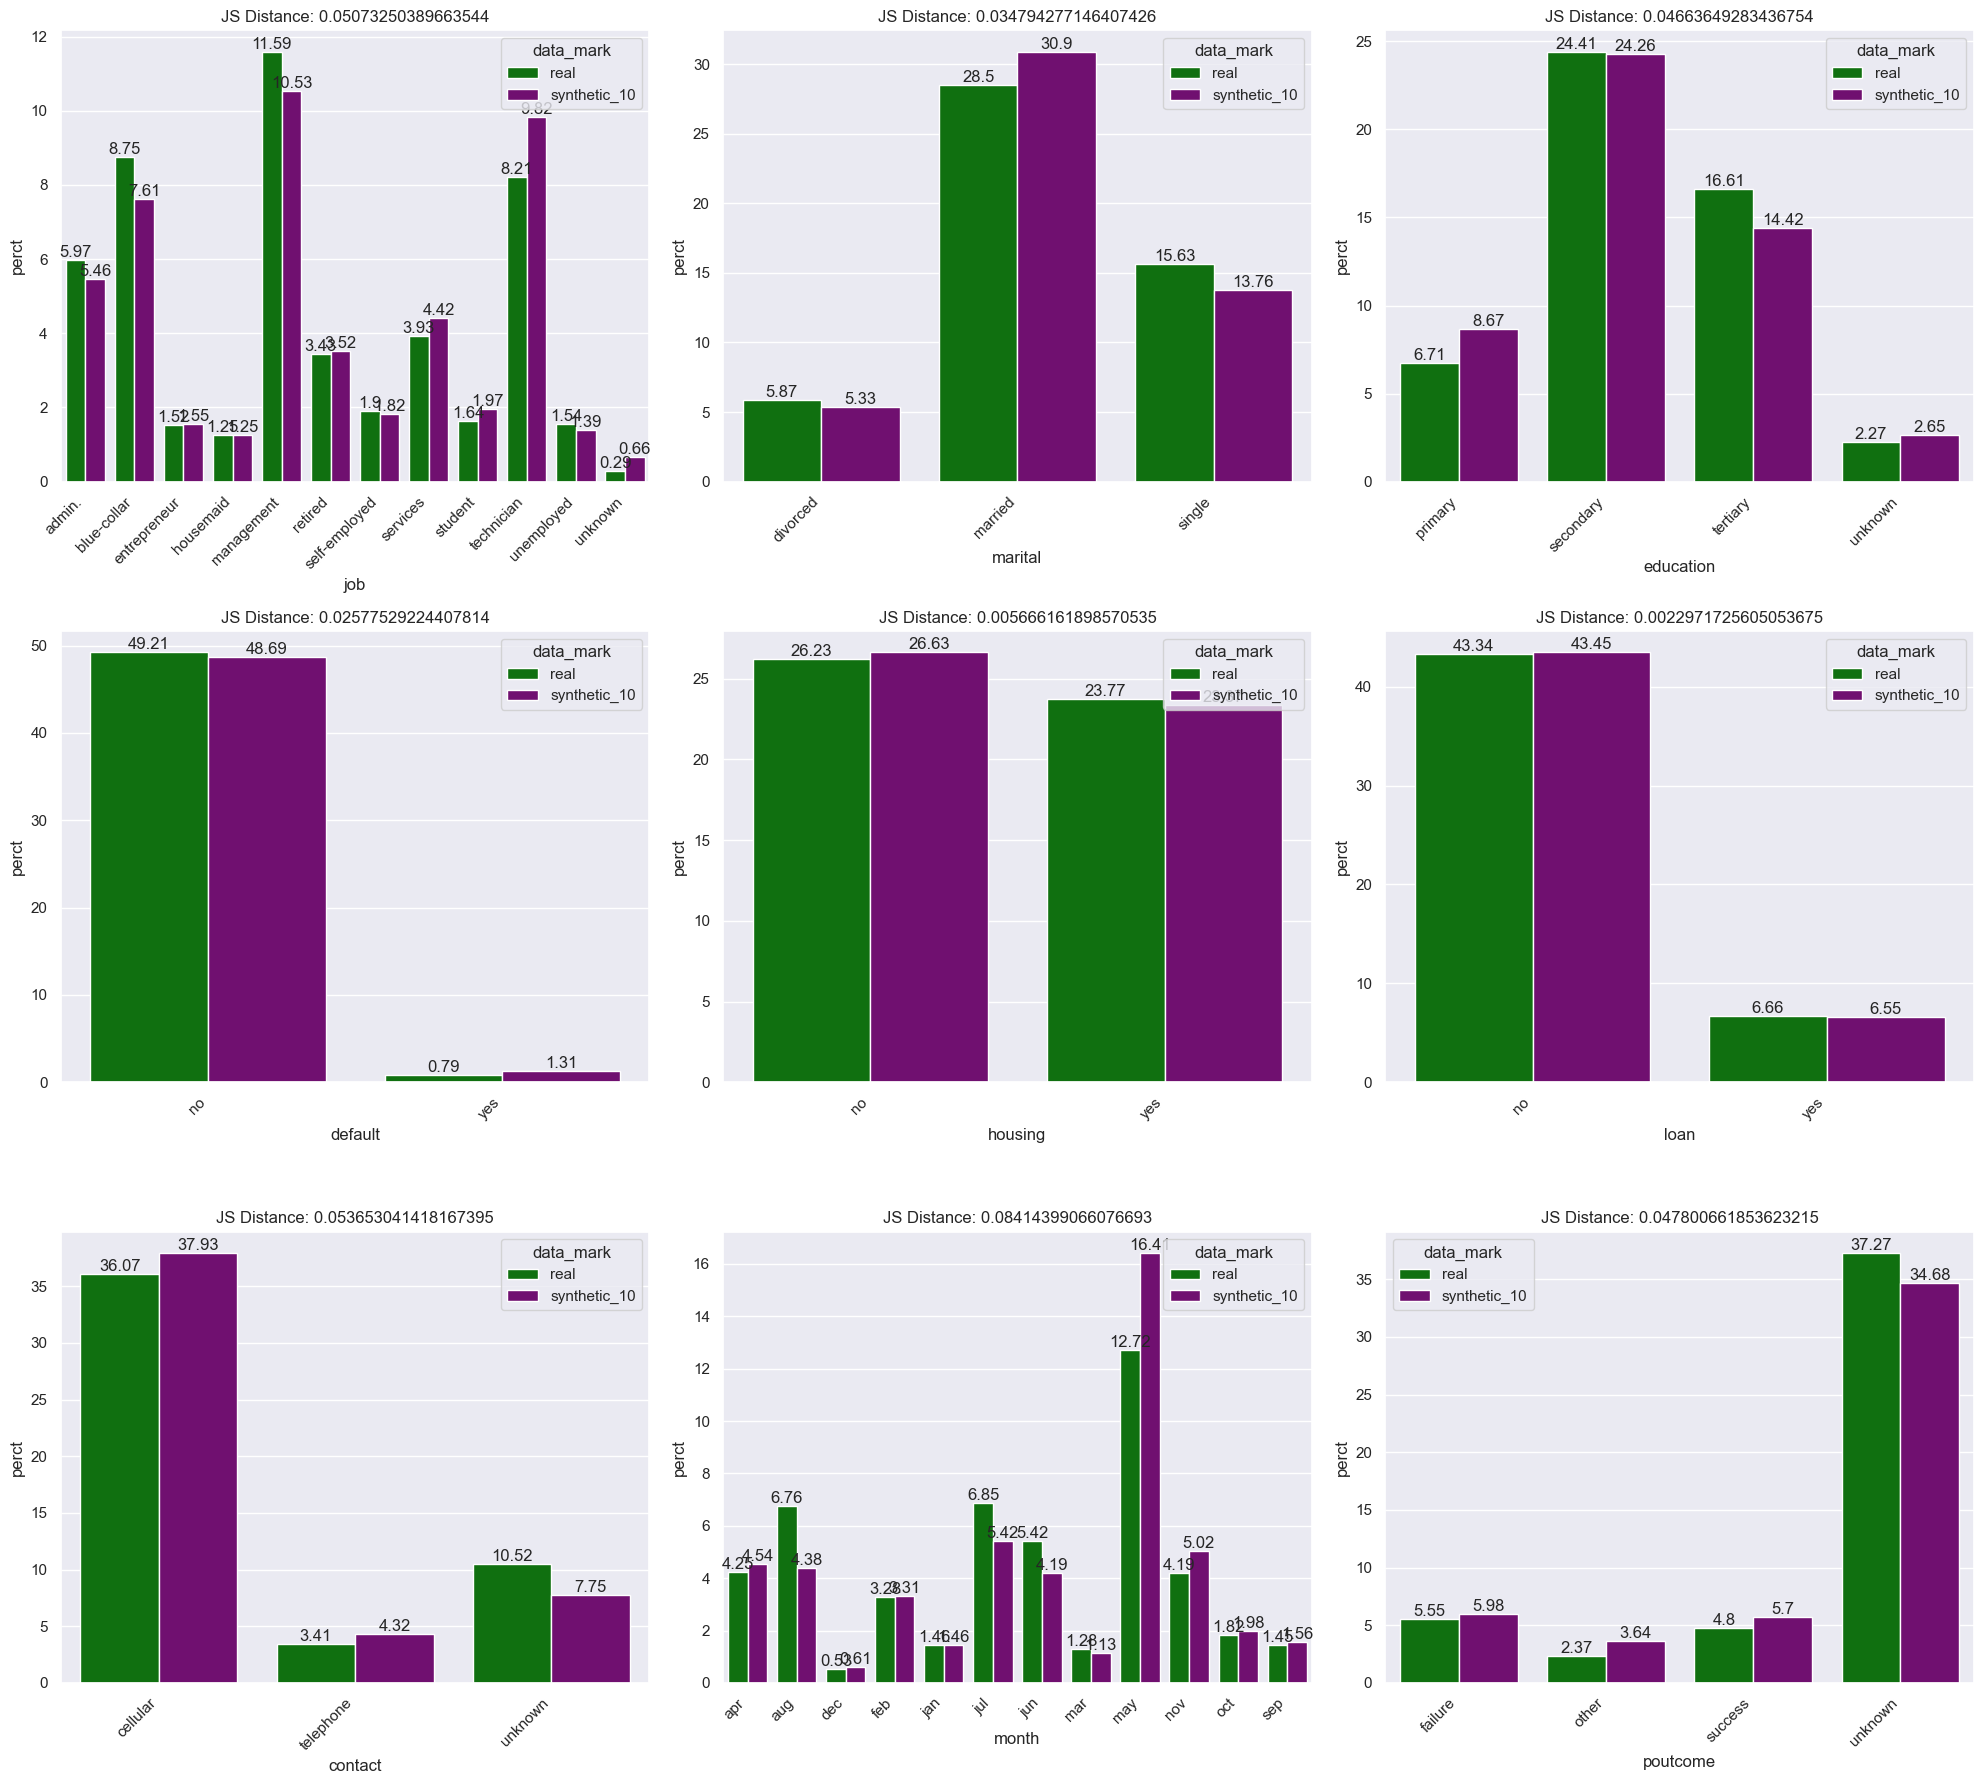

In [15]:
plot_cat_feature_distribution_per_group(compare_cat_df1, group_col='data_mark', 
                                        n_rows=3, n_cols=3, exclude_cols=['data_mark'], 
                                        figsize=[20, 18], font_size=12, palette=['green', 'purple'],
                                        group_values=['real', 'synthetic_10'], enable_dist_comp=True)

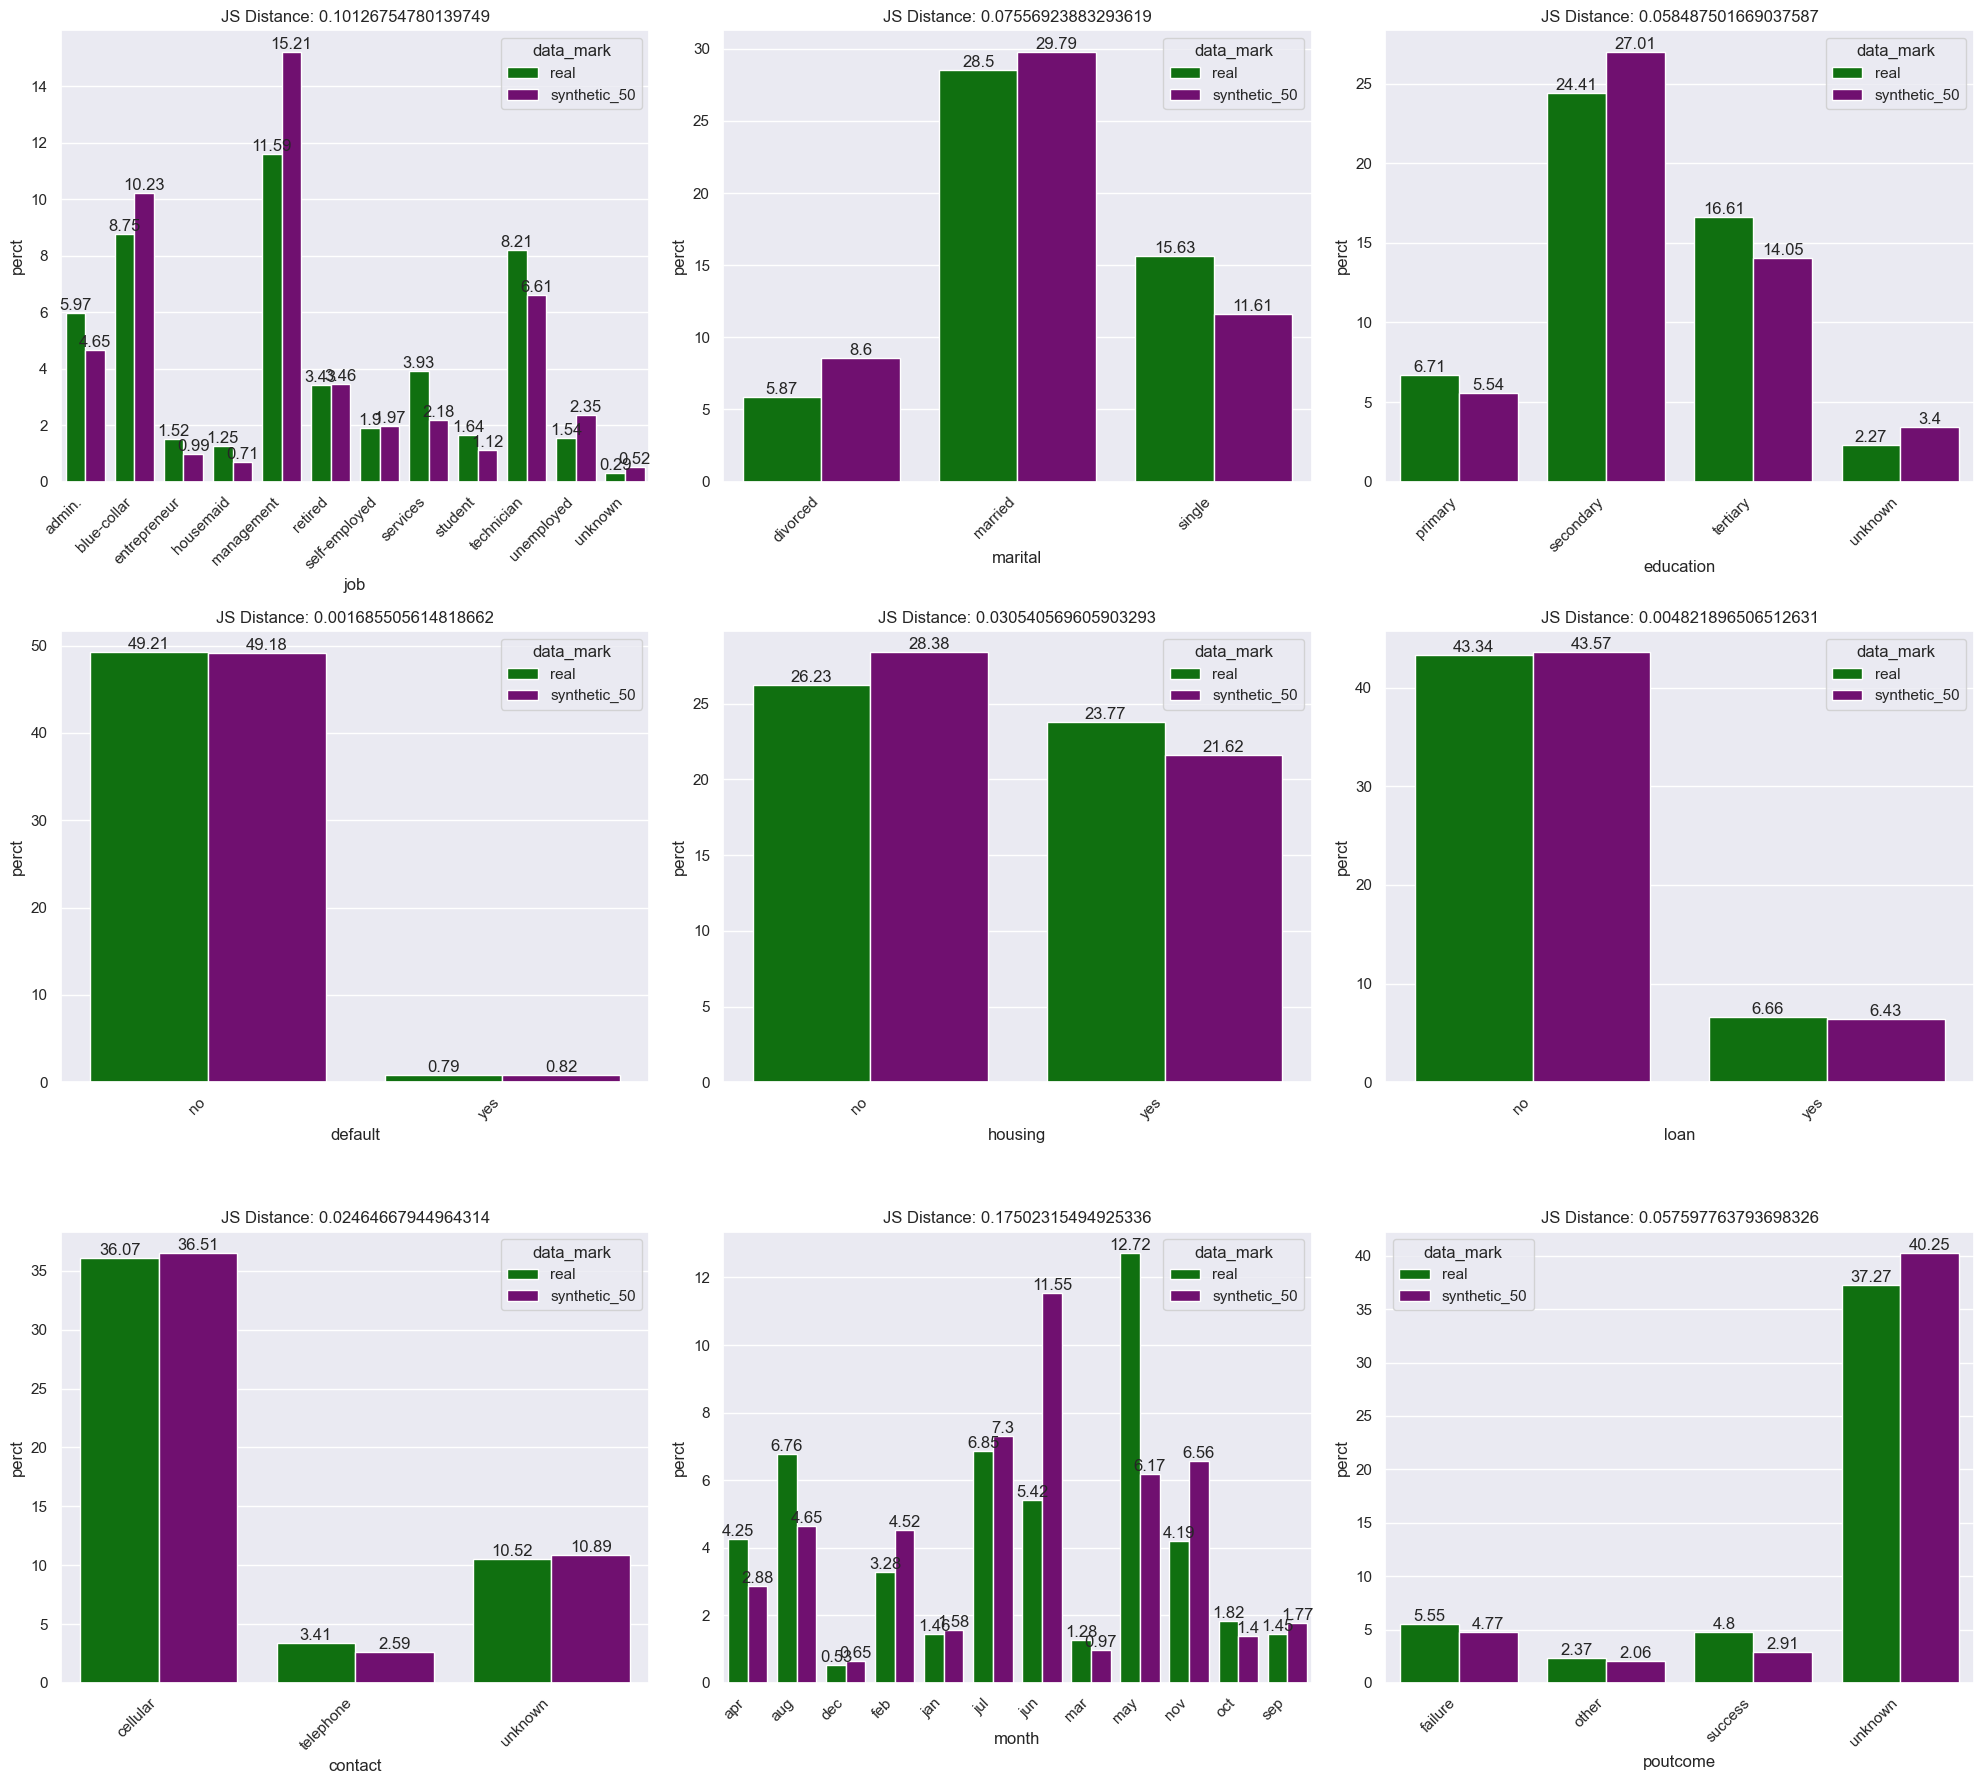

In [16]:
plot_cat_feature_distribution_per_group(compare_cat_df2, group_col='data_mark', 
                                        n_rows=3, n_cols=3, exclude_cols=['data_mark'], 
                                        figsize=[20, 18], font_size=12, palette=['green', 'purple'],
                                        group_values=['real', 'synthetic_50'], enable_dist_comp=True)

### Compare Model Efficacy

In [8]:
model_params = {'num_leaves': 4, 'learning_rate': 0.17937097905882862,
                'bagging_fraction': 0.8506740422636537, 
                'feature_fraction': 0.6643670461510903,
                'bagging_freq': 18, 'min_data_in_leaf': 1133,
                'num_iterations': 2956, 'objective': 'binary',
                'metric': 'auc', 'random_state': 10,
                'verbosity': -1, 'boosting': 'gbdt',
                'num_threads': 4}

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

syn_X_train_10[cat_cols] = syn_X_train_10[cat_cols].astype('category')
syn_X_train_50[cat_cols] = syn_X_train_50[cat_cols].astype('category')

In [9]:
model_real = LGBMClassifier(**model_params)
model_real.fit(X_train, y_train)
y_pred1 = model_real.predict(X_test)
auc = roc_auc_score(y_test, y_pred1)
avp = average_precision_score(y_test, y_pred1)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.8428958948887189, Testing Average Precision is 0.7699960261639714


In [10]:
model_syn10 = LGBMClassifier(**model_params)
model_syn10.fit(syn_X_train_10, y_train)
y_pred2 = model_syn10.predict(X_test)
auc = roc_auc_score(y_test, y_pred2)
avp = average_precision_score(y_test, y_pred2)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.5244106903231588, Testing Average Precision is 0.4865448058042881


In [11]:
model_syn50 = LGBMClassifier(**model_params)
model_syn50.fit(syn_X_train_50, y_train)
y_pred3 = model_syn50.predict(X_test)
auc = roc_auc_score(y_test, y_pred3)
avp = average_precision_score(y_test, y_pred3)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.4722942835751265, Testing Average Precision is 0.46077795232084606


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

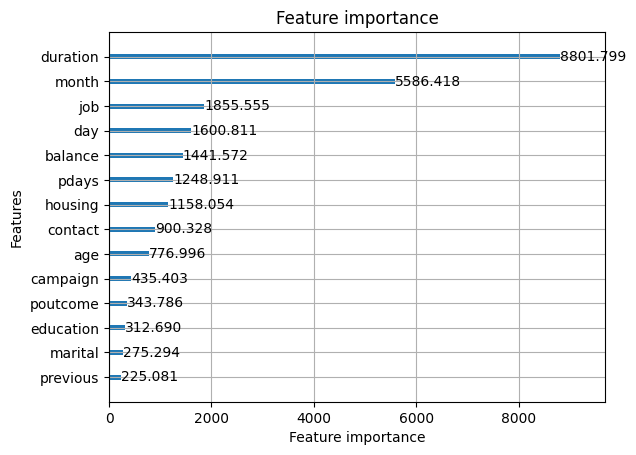

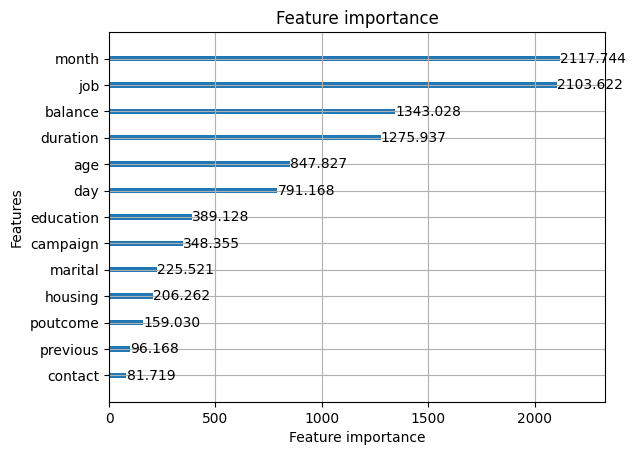

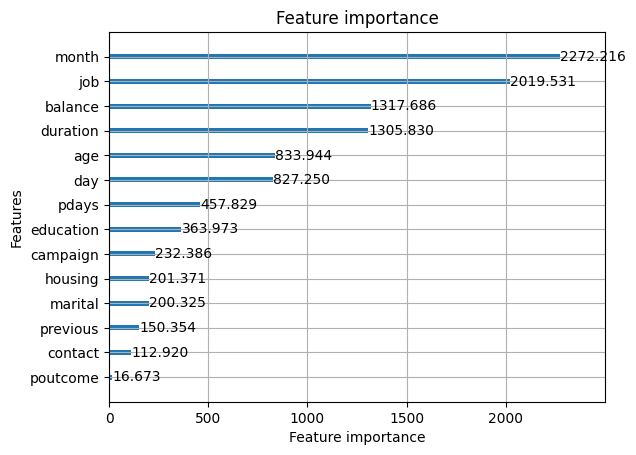

In [15]:
display(lgb.plot_importance(model_real, importance_type='gain'))

display(lgb.plot_importance(model_syn10, importance_type='gain'))

display(lgb.plot_importance(model_syn50, importance_type='gain'))